# CS461 Homework Assignment 1: Search Algorithms to Solve Frozen Lake

## Setup
### Software Requirements

The packages used in this homework have been tested on Ubuntu and macOS environments. If you are working on Windows, please note the following:

- **Core Functionalities:** The core search algorithms and graph-related functionalities will work on Windows. However, you may encounter limitations with rendering capabilities when using Gymnasium and other visualization tools.

- **Rendering Limitations on Windows:** Due to differences in graphical support and dependencies, rendering functionalities might not perform as expected on Windows. It is your responsibility to address these issues if you choose to work directly on a Windows system.

- **Recommended Solutions:**
  - **Virtual Machine:** Consider running a virtual machine with Ubuntu or another Linux distribution that supports the required packages and rendering capabilities without compatibility issues.
  - **Windows Subsystem for Linux (WSL):** Alternatively, use WSL to create a Linux environment on your Windows system. This approach allows you to run Linux-based tools and packages directly on your Windows machine, mitigating compatibility concerns.

By following these recommendations, you can ensure a smoother setup process and avoid common pitfalls associated with running these packages on Windows. If you choose to work on Windows without these additional steps, be prepared to troubleshoot and resolve any rendering issues independently. 

### Setting Up Your Virtual Environment

To ensure that you have all the necessary dependencies and tools for this assignment, we have provided a Conda environment configuration file (`environment.yml`). This file specifies all the packages and versions you will need to successfully run your code and complete the assignment. 

#### Steps to Set Up the Conda Environment:

1. **Download the `environment.yml` File:**
   - Ensure that you have the `environment.yml` file available in your working directory. This file contains the configuration for the required environment.

2. **Create the Conda Environment:**
   - Open your terminal or command prompt.
   - Navigate to the directory where the `environment.yml` file is located.
   - Run the following command to create a new Conda environment:
     ```bash
     conda env create -f environment.yml
     ```
   - This command will read the `environment.yml` file and set up the environment with all specified packages and dependencies.

3. **Activate the Environment:**
   - Once the environment is created, activate it using the command:
     ```bash
     conda activate your_environment_name
     ```
   - Replace `your_environment_name` with the name specified in the `environment.yml` file, or use the default name if provided.

4. **Verify the Environment:**
   - To ensure everything is set up correctly, you can check the installed packages:
     ```bash
     conda list
     ```
   - This will display a list of installed packages and their versions.
### Import the Required Libraries
Ensure you have all the necessary libraries installed. Use the following imports to set up your environment:

In [1]:
# Import necessary libraries
import gymnasium as gym
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython import display

# Set matplotlib to render inline in Jupyter Notebook
%matplotlib inline

## Rendering the Environment Inline in Jupyter Notebook
To visualize the agent's actions within the Frozen Lake environment, we'll use a function that renders frames inline in the Jupyter Notebook. This function captures the environment's state as an RGB array and displays it using Matplotlib.

In [2]:
# Function to render the frame and display it in the notebook
def render_frame(env):
    # Capture the frame as an RGB array
    frame = (
        env.render()
        if isinstance(env.render(), np.ndarray)
        else env.render(mode="rgb_array")
    )

    # Display the captured frame using Matplotlib
    plt.imshow(frame)
    plt.axis("off")  # Hide the axis for better visual appearance
    display.display(plt.gcf())
    display.clear_output(
        wait=True
    )  # Clear the output to update the frame for the next step

### Transforming Actions into Numeric Values

The following helper function is provided to transform a list of actions represented by strings into corresponding numeric values. This transformation simplifies the representation of actions, making it easier to handle them programmatically, especially when implementing search algorithms.

The function maps the actions as follows:
- `'left'` is mapped to `0`
- `'down'` is mapped to `1`
- `'right'` is mapped to `2`
- `'up'` is mapped to `3`

Any occurrences of `-1` in the list are removed since they do not represent valid actions. This ensures that the list of actions is clean and ready for use in further processing.

In [3]:
def transform_actions(actions):
    action_map = {"left": 0, "down": 1, "right": 2, "up": 3}
    return [action_map[action] for action in actions if action != -1]

## Customizing the Environment with Action Costs

To make the search algorithms more realistic and applicable, we introduce action costs to the Frozen Lake environment. The costs associated with each action help search algorithms make better decisions by considering the expense of each move.

We achieve this by creating a custom Gym wrapper called `ActionCostWrapper`, which modifies the environment to include action costs for each move (left, down, right, up).

In [4]:
# Custom Gym wrapper to add action costs to the environment
class ActionCostWrapper(gym.Wrapper):
    def __init__(self, env, action_costs=None):
        """
        Initializes the ActionCostWrapper with the specified action costs.

        Parameters:
        - env: The Gym environment to be wrapped.
        - action_costs: A list specifying the cost of each action in the order: [left, down, right, up].
                        Defaults to [1, 1, 1, 1] if not provided.
        """
        super().__init__(env)
        # Define default costs if not provided
        if action_costs is None:
            action_costs = [1, 1, 1, 1]  # Default cost for left, down, right, up
        self.action_costs = action_costs

    def step(self, action):
        """
        Modifies the step function to include action costs.

        Parameters:
        - action: The action taken by the agent (0: left, 1: down, 2: right, 3: up).

        Returns:
        - next_state: The state resulting from the action.
        - reward: The reward adjusted for action cost.
        - done: A boolean indicating if the episode has ended.
        - truncated: A boolean indicating if the episode was truncated.
        - info: Additional information from the environment.
        """
        # Take a step in the environment
        next_state, reward, done, truncated, info = self.env.step(action)

        # Subtract the action cost from the reward to represent the cost
        cost = self.action_costs[action]
        reward -= cost

        # Return the modified results
        return next_state, reward, done, truncated, info

## Visualizing the Environment as a Graph with Action Costs

The following helper function generates a graph representation of the Frozen Lake environment, where each node represents a state, and each directed edge corresponds to an action taken between states. Edges are labeled with both the action taken and its associated cost, providing a comprehensive visualization that reflects the modified environment's dynamics.

This graph is not only useful for visualization but also serves as an input for your graph search algorithms, allowing you to explore and find optimal paths based on action costs within the environment.

In [5]:
# Function to create and display the graph of the environment with action costs
def get_graph(env, action_meanings=None):
    if action_meanings is None:
        action_meanings = ["left", "down", "right", "up"]
        action_costs = [1, 2, 1, 2]

    G = nx.DiGraph()  # Initialize a directed graph

    # Iterate over all possible states and actions to build the graph
    for state in range(env.observation_space.n):
        for action in range(env.action_space.n):
            env.reset()
            env.s = state  # Set the environment to the current state
            next_state, reward, done, truncated, info = env.step(action)

            # Add nodes to the graph
            if not (done and state == next_state):  # Avoid terminal self-loops
                G.add_node(state, label=f"State {state}")
                G.add_node(next_state, label=f"State {next_state}")

                # Get the action cost from the environment's action cost list
                action_cost = (
                    env.action_costs[action]
                    if hasattr(env, "action_costs")
                    else action_costs[action]
                )

                # Check if an edge already exists, and update it if necessary
                if G.has_edge(state, next_state):
                    # Append the new action and cost to the existing edge label
                    current_label = G[state][next_state]["action"]
                    current_cost = G[state][next_state]["cost"]
                    G[state][next_state][
                        "action"
                    ] = f"{current_label}, {action_meanings[action]}"
                    G[state][next_state]["cost"] = f"{current_cost}, {action_cost}"
                else:
                    # Add new edge with the action label and cost
                    G.add_edge(
                        state,
                        next_state,
                        action=action_meanings[action],
                        cost=action_cost,
                    )

    # Clear any previous figures
    plt.clf()
    plt.close()

    # Visualization using NetworkX
    pos = nx.spring_layout(G, k=1.5, iterations=100)
    plt.figure(figsize=(14, 10))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=700,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=15,
    )

    # Generate consolidated edge labels with actions and costs for better readability
    edge_labels = {
        (u, v): f"{d['action']} (Cost: {d['cost']})" for u, v, d in G.edges(data=True)
    }
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_color="red", font_size=8, label_pos=0.3
    )

    plt.title("Discrete Gym Environment as Graph with Actions and Costs")
    plt.show(
        block=True
    )  # Ensure the plot is shown and the script waits until the window is closed

    return G

## Creating and Modifying the Frozen Lake Environment

The following code sets up the Frozen Lake environment with a custom map layout and wraps it with the `ActionCostWrapper` to include action costs for each move. This setup allows the environment to reflect more realistic decision-making scenarios where each action has a specific cost associated with it.

#### Modifications:
- The environment is created with a specific layout (`desc`) and set to `is_slippery=False` to ensure deterministic movements.
- The environment is wrapped using the `ActionCostWrapper` to incorporate action costs, which are essential for implementing and testing cost-aware search algorithms like A*. **Notice that each action has a different cost associated with it,** which affects the agent’s decision-making process and the overall path chosen by the search algorithm.

In [6]:
# Create the Frozen Lake environment with a custom map layout
env = gym.make(
    "FrozenLake-v1",
    desc=[
        "SFFH",
        "FHFF",
        "FFFF",
        "FFHG",
    ],  # Custom map layout with Start (S), Frozen (F), Hole (H), and Goal (G)
    is_slippery=False,  # Make the environment deterministic
    render_mode="rgb_array",  # Set render mode to capture frames as RGB arrays
)

# Apply the ActionCostWrapper to include action costs for each move
env = ActionCostWrapper(
    env, action_costs=[1, 2, 1, 2]
)  # Costs: left=1, down=2, right=1, up=2
env = env.unwrapped

## Resetting the Environment

Before starting any interaction with the environment, it's important to reset it to its initial state. The reset operation initializes the environment, placing the agent at the starting position and preparing it for a new episode.

In [7]:
# Reset the environment
obs, info = env.reset()

## Generating and Displaying the Graph

The following code uses the provided helper function `get_graph` to create and display a graph representation of the environment. This graph visualizes the states and the possible actions between them, along with the associated costs, allowing you to better understand the dynamics of the environment and the impact of different actions.

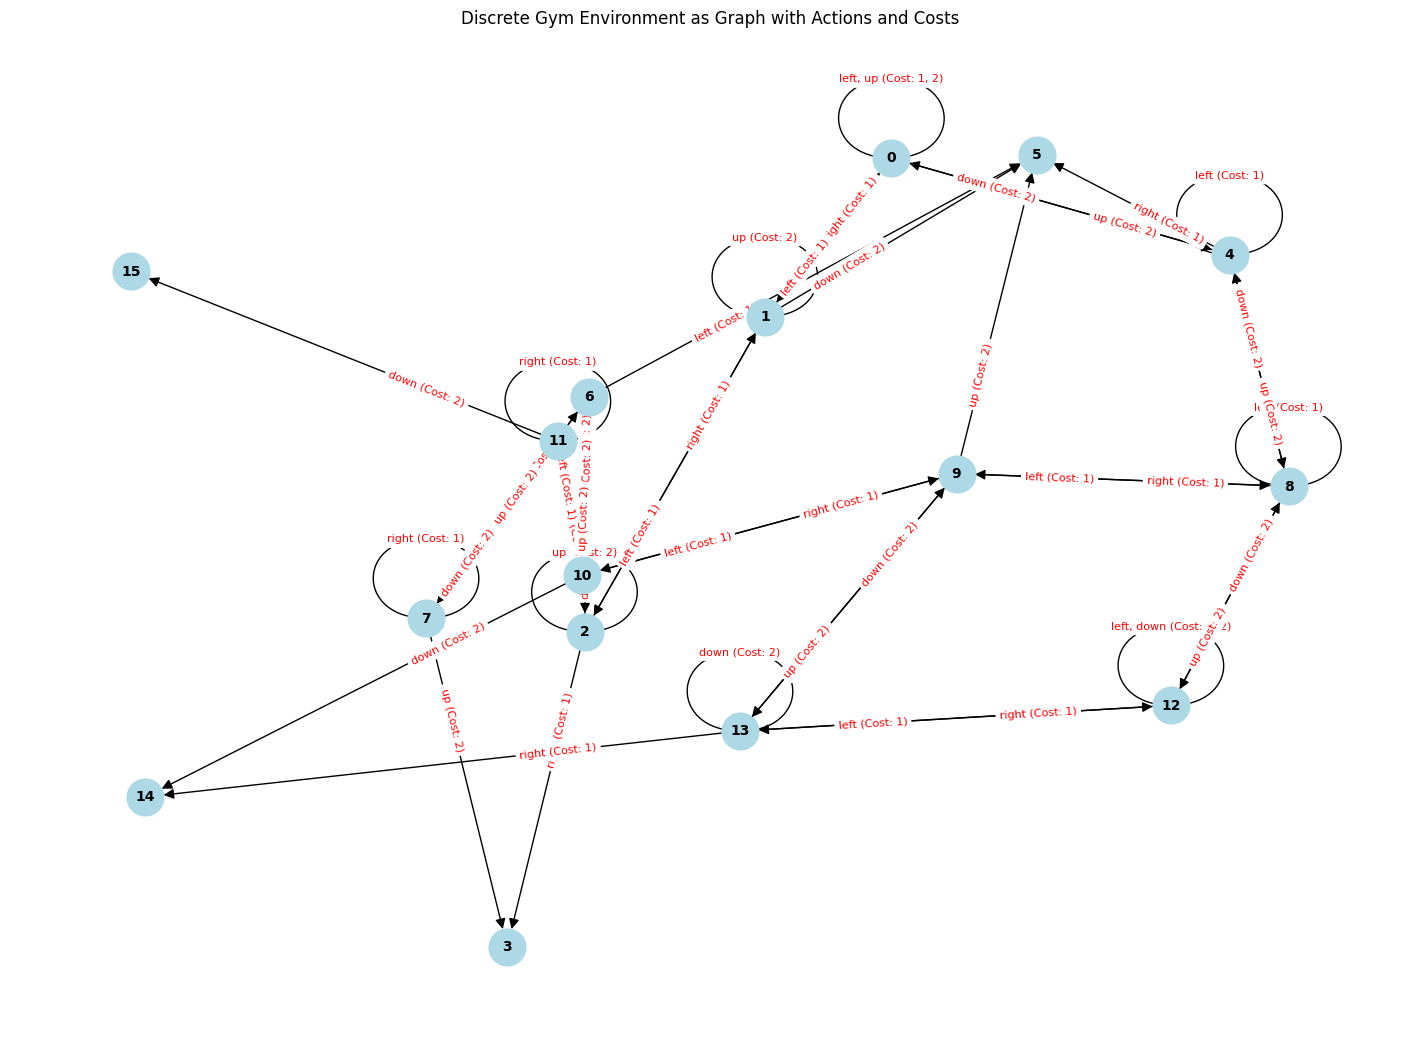

In [8]:
# Generate and display the graph
G = get_graph(env)

In [9]:
# Reset the environment
obs, info = env.reset()

## Visualizing the Environment State

To gain a better understanding of the environment and observe how the agent interacts with it, we use the `render_frame` function to visualize the current state of the environment. This provides a clear, visual representation of the environment, which can be helpful for debugging and understanding the impact of actions taken by the agent.

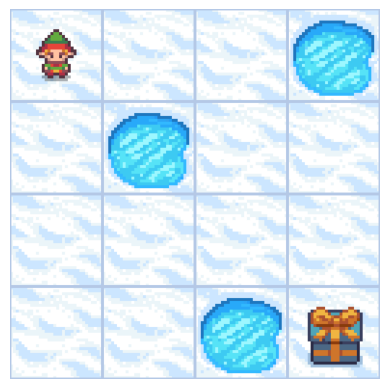

In [10]:
# Render and display the current state of the environment
render_frame(env)

## Depth-First Search (DFS) Algorithm

Depth-First Search (DFS) is a fundamental graph traversal algorithm used to explore nodes and edges of a graph systematically. DFS starts at a given node (often the start state) and explores as far as possible along each branch before backtracking. This approach is akin to going as deep as possible down one path and then moving to the next unexplored path once it hits a dead end or the goal state.

## Key Characteristics of DFS:
- **LIFO Structure:** DFS uses a stack (Last-In-First-Out) structure to keep track of the nodes to explore next. This can be implemented using an explicit stack or through recursion.
- **Path Exploration:** DFS explores each path to its maximum depth before moving on to other branches, making it suitable for problems where a path to a goal is more likely to be found deep within the graph.
- **Backtracking:** If a path doesn’t lead to the goal, DFS backtracks to the previous node and explores alternative paths.
- **Not Optimal:** DFS does not guarantee the shortest path to the goal due to its nature of exploring depth-first rather than breadth-first.

## Task: Implementing DFS to Find a Path in the Graph

Below is the skeleton of the DFS function that you need to complete. The function should traverse the graph `G` and return a path from the starting node to the goal node. The function uses DFS to explore the graph and records the path once the goal is found.

In [11]:
def dfs(G, start, goal):
    """
    Perform Depth-First Search (DFS) on the graph to find a path from start to goal.

    Parameters:
    - G: A directed graph where nodes represent states and edges represent actions with costs.
    - start: The starting node for the DFS traversal.
    - goal: The goal node to reach.

    Returns:
    - path: A list of actions representing the path from start to goal if found, otherwise an empty list.
    """

    print(f"Start: {start}, Goal: {goal}")
    print(f"Graph Nodes: {list(G.nodes)}")
    print(f"Graph Edges: {list(G.edges)}")
    print(f"Graph Edges Data: {list(G.edges.data())}")

    # Initialize the stack for DFS traversal
    stack = [(start, [])]

    # Initialize the visited set to keep track of visited nodes
    visited = set()

    # Perform DFS traversal
    while stack:
        current_node, path = stack.pop()
        print(f"Current Node: {current_node}, Path: {path}")

        # Check if the current node is the goal
        if current_node == goal:
            print(f"Path found: {path}")
            return path

        # Add the current node to the visited set
        visited.add(current_node)

        print(f"Neighbors: {list(G.neighbors(current_node))}")

        # Iterate over the neighbors of the current node
        for neighbor in G.neighbors(current_node):
            # Check if the neighbor is not visited
            if neighbor not in visited:
                print(f"Adding Neighbor: {neighbor}")

                # Add the neighbor to the stack with the updated path
                stack.append((neighbor, path + [G[current_node][neighbor]["action"]]))

                print(f"Stack: {stack}")

    print("No path found!")
    return []

## Visualizing the Agent's Path to the Goal

Once you've implemented the DFS algorithm and generated a path from the start to the goal, you can use the following cell to check whether your agent can achieve the goal in the Frozen Lake environment. This cell resets the environment, transforms the path into corresponding actions, and executes these actions step-by-step, rendering each state of the environment to visualize the agent's journey.

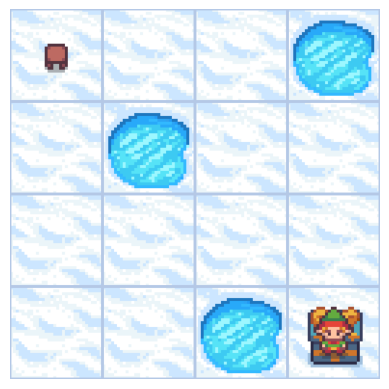

In [12]:
# Print the path found by the DFS algorithm
path = dfs(G, 0, 15)
print(path)

# Reset the environment to the initial state
obs, info = env.reset()

# Transform the path into corresponding actions
actions = transform_actions(path)  # Maps directions to numerical actions

# Perform actions and render each step to visualize the agent's path
for action in actions:
    obs, _, done, _, _ = env.step(action)
    render_frame(env)  # Render the current state of the environment inline
    time.sleep(0.5)  # Add a delay to slow down the visualization for better observation
    if done:  # Stop if the goal is reached
        break

## Breadth-First Search (BFS) Algorithm

Breadth-First Search (BFS) is another fundamental graph traversal algorithm used to explore nodes and edges of a graph systematically. Unlike DFS, BFS explores all nodes at the present depth level before moving on to nodes at the next depth level. This approach ensures that BFS finds the shortest path (in terms of the number of edges) to the goal if such a path exists.

## Key Characteristics of BFS:
- **FIFO Structure:** BFS uses a queue (First-In-First-Out) structure to keep track of the nodes to explore next. Nodes are processed in the order they are added to the queue, ensuring that nodes at each level are fully explored before descending to the next level.
- **Level-by-Level Exploration:** BFS explores nodes level by level, making it ideal for finding the shortest path in unweighted graphs or graphs where all edges have the same cost.
- **Optimality:** BFS guarantees finding the shortest path to the goal in terms of the number of edges traversed, which is an advantage over DFS in scenarios where the path length matters.
- **Memory Usage:** BFS can require more memory than DFS because it stores all nodes at the current level before moving deeper, which can lead to large queue sizes for wide graphs.

## Task: Implementing BFS to Find a Path in the Graph

Below is the skeleton of the BFS function that you need to complete. The function should traverse the graph `G` and return the shortest path from the starting node to the goal node. The function uses BFS to explore the graph and records the path once the goal is found.

In [13]:
def bfs(G, start, goal):
    """
    Perform Breadth-First Search (BFS) on the graph to find the shortest path from start to goal.

    Parameters:
    - G: A directed graph where nodes represent states and edges represent actions with costs.
    - start: The starting node for the BFS traversal.
    - goal: The goal node to reach.

    Returns:
    - path: A list of actions representing the shortest path from start to goal if found, otherwise an empty list.
    """

    # Initialize the queue for BFS traversal
    queue = [(start, [])]

    print(f"Start: {start}, Goal: {goal}")
    print(f"Graph Nodes: {list(G.nodes)}")
    print(f"Graph Edges: {list(G.edges)}")
    print(f"Graph Edges Data: {list(G.edges.data())}")
    print(f"Queue: {queue}")

    # Initialize the visited set to keep track of visited nodes
    visited = set()

    # Perform BFS traversal
    while queue:
        current_node, path = queue.pop(0)

        print(f"Current Node: {current_node}, Path: {path}")

        # Check if the current node is the goal
        if current_node == goal:
            return path

        # Add the current node to the visited set
        visited.add(current_node)

        print(f"Neighbors: {list(G.neighbors(current_node))}")

        # Iterate over the neighbors of the current node
        for neighbor in G.neighbors(current_node):
            # Check if the neighbor is not visited
            if neighbor not in visited:
                print(f"Adding Neighbor: {neighbor}")

                # Add the neighbor to the queue with the updated path
                queue.append((neighbor, path + [G[current_node][neighbor]["action"]]))

                print(f"Queue: {queue}")

    # Return an empty list if no path is found
    print("No path found!")
    return []

## Visualizing the Agent's Path to the Goal

Once you've implemented the BFS algorithm and generated a path from the start to the goal, you can use the following cell to check whether your agent can achieve the goal in the Frozen Lake environment. This cell resets the environment, transforms the path into corresponding actions, and executes these actions step-by-step, rendering each state of the environment to visualize the agent's journey.

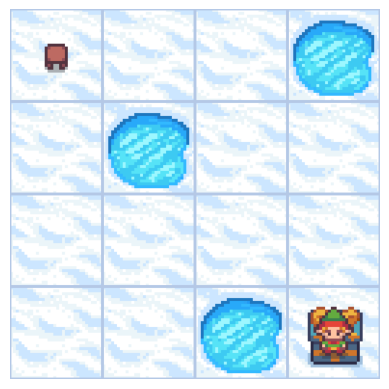

In [14]:
# Print the path found by the BFS algorithm
path = bfs(G, 0, 15)
print(path)

# Reset the environment to the initial state
obs, info = env.reset()

# Transform the path into corresponding actions
actions = transform_actions(path)  # Maps directions to numerical actions

# Perform actions and render each step to visualize the agent's path
for action in actions:
    obs, _, done, _, _ = env.step(action)
    render_frame(env)  # Render the current state of the environment inline
    time.sleep(0.5)  # Add a delay to slow down the visualization for better observation
    if done:  # Stop if the goal is reached
        break

## Introduction to Cost-Sensitive Search

Cost-sensitive search algorithms, such as A*, are designed to find optimal paths in graphs where actions or transitions between states have associated costs. Unlike basic search algorithms like DFS or BFS, which focus purely on the structure of the graph (nodes and edges), cost-sensitive algorithms consider the cumulative cost of actions, aiming to minimize the total cost to reach the goal.

In these algorithms, each action's cost influences the agent's decision-making process, steering it towards the most cost-effective path rather than just the shortest in terms of steps or depth. This approach is particularly useful in environments where actions have varying costs, such as navigating through terrains with different difficulties, managing resources, or optimizing time.

Cost-sensitive search algorithms are crucial for scenarios where not all actions are equal, and finding the optimal solution requires balancing the number of steps with the costs incurred along the way.

## Heuristic Function for Search Algorithms

A heuristic function is a crucial component of informed search algorithms, such as Greedy Search and A*. It provides an estimate of the cost or distance from a given state to the goal state, guiding the search process more intelligently compared to uninformed methods like BFS or DFS. The heuristic function does not guarantee exact costs but aims to approximate them in a way that improves the efficiency of the search.

## Key Characteristics of a Heuristic Function:
- **Guidance:** A well-chosen heuristic helps the algorithm make better decisions by prioritizing nodes that appear closer to the goal, thus reducing the search space and time.
- **Estimation:** The heuristic provides an estimate of the cost to reach the goal from a given node. It is not required to be perfect but should be as accurate as possible without excessive computation.
- **Influence on Performance:** The quality of the heuristic directly affects the performance of the search algorithm. A good heuristic can significantly speed up the search, while a poor heuristic can lead to inefficient exploration or even mislead the algorithm.

### Task: Designing Your Heuristic Function

Your task is to design a heuristic function that best fits the Frozen Lake environment. This heuristic should effectively guide the search towards the goal state, balancing between underestimating and overestimating the actual cost to ensure efficient exploration without missing optimal paths.

In [15]:
def heuristic(current_state, goal_state):
    """
    Heuristic function to estimate the cost from the current state to the goal state.

    Parameters:
    - current_state: The current node or state in the graph.
    - goal_state: The goal node or state to reach.

    Returns:
    - estimated_cost: An estimate of the cost from the current state to the goal state.
    """
    # Implement your heuristic calculation here
    estimated_cost = 0  # Replace with your heuristic logic

    return estimated_cost

## Evaluating the Admissibility of Your Heuristic

After designing your heuristic function, it's crucial to evaluate whether it is admissible and consistent. An admissible heuristic is one that never overestimates the true cost to reach the goal, ensuring that A* Search can guarantee finding the optimal path. A consistent (or monotonic) heuristic additionally ensures that the estimated cost is always less than or equal to the estimated cost from a neighboring node plus the cost to reach that neighbor, which helps A* avoid revisiting nodes unnecessarily.

### Task: Assess the Admissibility of Your Heuristic

1. **Is Your Heuristic Admissible?**
   - Determine whether your heuristic is admissible by checking if it always underestimates or exactly matches the true cost to reach the goal from any given state.
   - Provide a brief explanation of why your heuristic is admissible. Consider edge cases or specific scenarios in the Frozen Lake environment to support your reasoning.

2. **If Not Admissible, Why?**
   - If your heuristic is not admissible, explain why you chose it despite this limitation.
   - Discuss any trade-offs you made in terms of efficiency, simplicity, or performance. For example, you might have prioritized a heuristic that performs well in most cases but occasionally overestimates the cost.

3. **Consistency Check:**
   - Consider whether your heuristic is consistent. A consistent heuristic satisfies the triangle inequality, ensuring that the heuristic estimate does not exceed the actual step cost between nodes plus the estimated cost from the neighboring node to the goal.
   - Consistency helps prevent A* from needing to re-explore nodes, enhancing efficiency.

### Your Task:

Reflect on your heuristic and document:
- Whether it is admissible and why.
- If it is not admissible, explain your rationale for using it and what benefits it provides despite its limitations.

This analysis will help you understand the impact of your heuristic on the performance and outcome of the A* algorithm, providing valuable insights into the trade-offs involved in heuristic design. Please provide your analysis as markdown below.  

## Analysis:


## Greedy Search Algorithm

Greedy Search is a heuristic-based search algorithm that prioritizes expanding the most promising node based on a heuristic function. Unlike BFS or DFS, Greedy Search does not explore nodes in a systematic order but rather chooses the path that appears most favorable at each step according to the heuristic, often aiming to minimize the estimated distance to the goal.

## Key Characteristics of Greedy Search:
- **Heuristic-Driven:** Greedy Search uses a heuristic function to evaluate which node to explore next, typically selecting the node that appears closest to the goal based on the heuristic.
- **Priority Queue:** It uses a priority queue (often implemented with a min-heap) to prioritize nodes with the lowest heuristic value, guiding the search towards the goal in what seems like the quickest path.
- **Non-Optimal:** Greedy Search does not guarantee the optimal path because it only considers the heuristic at each step and ignores the cumulative cost of the path so far. This can lead to suboptimal paths if the heuristic is not well-chosen.
- **Efficiency:** Greedy Search can be more efficient than exhaustive search methods (like BFS or DFS) when the heuristic is good, as it quickly homes in on the goal, but it can also get stuck in local minima if the heuristic is misleading.

## Task: Implementing Greedy Search to Find a Path in the Graph

Below is the skeleton of the Greedy Search function that you need to complete. The function should traverse the graph `G` using a heuristic to guide the search, returning a path from the starting node to the goal node. The Greedy Search uses the heuristic to explore the graph, aiming to reach the goal quickly by always moving towards the node that appears closest to the goal according to the heuristic. 

This approach is useful for cases where a quick, though not necessarily optimal, solution is desired, and the heuristic provides a reasonable estimate of the distance to the goal.

In [16]:
def greedy_search(G, start, goal, heuristic):
    """
    Perform Greedy Search on the graph to find a path from start to goal using a heuristic.

    Parameters:
    - G: A directed graph where nodes represent states and edges represent actions with costs.
    - start: The starting node for the Greedy Search.
    - goal: The goal node to reach.
    - heuristic: A function that estimates the cost from a given node to the goal.

    Returns:
    - path: A list of actions representing the path from start to goal if found, otherwise an empty list.
    """
    # Fill here
    return path

## Visualizing the Agent's Path to the Goal

Once you've implemented the Greedy Search algorithm and generated a path from the start to the goal, you can use the following cell to check whether your agent can achieve the goal in the Frozen Lake environment. This cell resets the environment, transforms the path into corresponding actions, and executes these actions step-by-step, rendering each state of the environment to visualize the agent's journey.

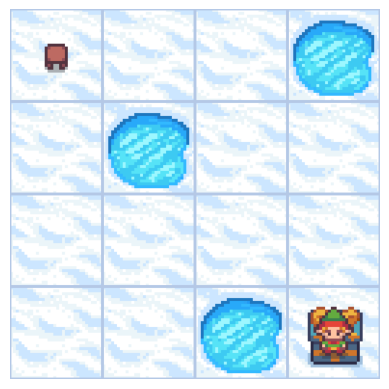

In [17]:
# Print the path found by the Greedy Search algorithm
path = greedy_search(G, 0, 15, heuristic)
print(path)

# Reset the environment to the initial state
obs, info = env.reset()

# Transform the path into corresponding actions
actions = transform_actions(path)  # Maps directions to numerical actions

# Perform actions and render each step to visualize the agent's path
for action in actions:
    obs, _, done, _, _ = env.step(action)
    render_frame(env)  # Render the current state of the environment inline
    time.sleep(0.5)  # Add a delay to slow down the visualization for better observation
    if done:  # Stop if the goal is reached
        break

## A* Search Algorithm

A* Search is a powerful and popular search algorithm that combines the strengths of both Uniform Cost Search and Greedy Search. It uses both the actual cost from the start node to the current node (g-cost) and a heuristic estimate (h-cost) of the cost from the current node to the goal. By combining these two values, A* aims to find the most cost-effective path to the goal while also considering the estimated distance.

## Key Characteristics of A* Search:
- **Heuristic and Cost-Driven:** A* uses both the actual cost (g-cost) and the heuristic estimate (h-cost) to evaluate nodes. The combined cost (f-cost = g-cost + h-cost) ensures that the search is guided efficiently while considering the real path costs.
- **Priority Queue:** A* uses a priority queue (often implemented with a min-heap) to prioritize nodes with the lowest combined cost (f-cost), balancing between exploring cheaper paths and paths that appear closer to the goal.
- **Optimality:** A* guarantees finding the optimal path to the goal if the heuristic is admissible (never overestimates the true cost) and consistent (satisfies the triangle inequality).
- **Efficiency:** A* can be very efficient when the heuristic is well-designed, as it reduces the search space by focusing on the most promising paths.

## Task: Implementing A* Search to Find a Path in the Graph

Below is the skeleton of the A* Search function that you need to complete. The function should traverse the graph `G` and return the optimal path from the starting node to the goal node. A* Search uses both the actual cost and the heuristic to guide the search and find the path with the lowest total cost.

In [18]:
def a_star(G, start, goal, heuristic):
    """
    Perform A* Search on the graph to find the optimal path from start to goal using a heuristic.

    Parameters:
    - G: A directed graph where nodes represent states and edges represent actions with costs.
    - start: The starting node for the A* Search.
    - goal: The goal node to reach.
    - heuristic: A function that estimates the cost from a given node to the goal.

    Returns:
    - path: A list of nodes representing the optimal path from start to goal if found, otherwise an empty list.
    """
    # Fill here
    return path

## Visualizing the Agent's Path to the Goal

Once you've implemented the A* Search algorithm and generated a path from the start to the goal, you can use the following cell to check whether your agent can achieve the goal in the Frozen Lake environment. This cell resets the environment, transforms the path into corresponding actions, and executes these actions step-by-step, rendering each state of the environment to visualize the agent's journey.

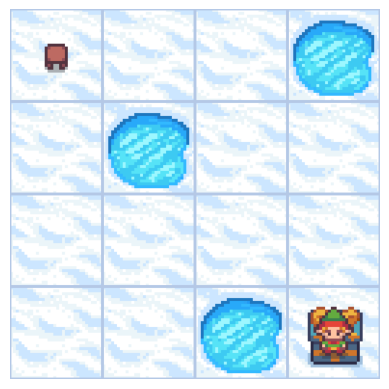

In [19]:
# Print the path found by the A* Search algorithm
path = a_star(G, 0, 15, heuristic)
print(path)

# Reset the environment to the initial state
obs, info = env.reset()

# Transform the path into corresponding actions
actions = transform_actions(path)  # Maps directions to numerical actions

# Perform actions and render each step to visualize the agent's path
for action in actions:
    obs, _, done, _, _ = env.step(action)
    render_frame(env)  # Render the current state of the environment inline
    time.sleep(0.5)  # Add a delay to slow down the visualization for better observation
    if done:  # Stop if the goal is reached
        break

## Conclusion

Congratulations on completing this assignment! You've successfully implemented both uninformed and informed search algorithms to solve a maze-like environment. By tackling the Frozen Lake problem, you’ve navigated through various search strategies, including Depth-First Search, Breadth-First Search, Greedy Search, and A* Search, each with its unique approach to finding paths through complex environments.

Through this exercise, you've explored how different algorithms prioritize exploration, cost, and heuristics to find optimal paths. While the environment here was a simplified version of real-world scenarios, the principles and algorithms you’ve applied are foundational to many state-of-the-art search techniques used in robotics, artificial intelligence, and game development. 

Remember, the key differences between your implementation and cutting-edge search applications lie mainly in the complexity of the environments and the sophistication of the heuristics and costs involved. Whether it’s navigating autonomous vehicles through a city, planning routes for delivery drones, or finding the best moves in strategic games, the core algorithms remain surprisingly similar.

By understanding these fundamental concepts, you've built a strong foundation that is directly applicable to more complex, real-world challenges. Keep exploring and pushing the boundaries of your skills—what you’ve learned here is just the beginning!